# Evolution of mining pool market shares - Stack Plot

## imports and functions

In [ ]:
from tmp import *

# Files needed 
with open('./1_block_attribution/miners_and_pools/miners_custom_color.json', 'r') as fp:
    miners = json.load(fp)

# this might take some seconds/minutes
with open('./dataset/blocks_attribution_0-556400.json', 'r') as fp:
    blocks = json.load(fp)

In [31]:
def ts2ymd(ts):
    return datetime.datetime.fromtimestamp(int(ts)).strftime('%Y-%m-%d')

def get_color_from_tag(tag):
    # returns a list with facecolor, edgecolor, hatch
    global miners
    hatch = '//' # in case it is needed
    c = ['#383838', '#383838', hatch]
    miner = find_miner_name(tag)
    if miner != 'unknown':
        try:
            c = [miners[miner]['config']['color'], miners[miner]['config']['color'], hatch]
        except Exception as e:
            print(e)
            c = [miners[miner]['config']['color'], miners[miner]['config']['color'], hatch]
    if tag == 'Other':
            c = ['#CDC9C9', '#CDC9C9', hatch]
    return c

def find_miner_name(string, upper=True):
    for miner in miners.keys():
        if upper:
            string = string.upper()
            if string in [name.upper() for name in miners[miner]['names'].keys()]:
                return miner
        elif string in miners[miner]['names'].keys():
            return miner
    for miner in miners.keys():
        if upper:
            string = string.upper()
            if string in [marker.upper() for marker in miners[miner]['markers'].keys()]:
                return miner
        elif string in miners[miner]['markers'].keys():
            return miner
    return 'unknown'

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

def sort_keys(keys):
    keys = list(keys)
    sorted_keys = []
    for k in ['AntPool', 'BTC.com', 'ViaBTC', 'DiscusFish / F2Pool', 'BTC.TOP', 'BTCC', 'HaoBTC', 'bixin', 'SlushPool', 'unknown']:
        if k in keys:
            sorted_keys.append(k)
    for k in keys:
        if k not in sorted_keys and k != 'Other':
            sorted_keys.append(k)
    sorted_keys.append('Other')
    return sorted_keys


def get_tag_perc(start, end, blocks):
    # Params:
    # start: first block height in period 
    # end: last block height in period 
    # blocks: data from blocks_attribution_0-$(current_blockheight).json
    
    # Outputs:
    # tag_perc: dict with tag as key and its percentage as value
    
    start = int(start)
    end = int(end)

    tag_nMinedBlocks = dict()
    tot_blocks_in_period = 0
    for h in blocks.keys():
        h = int(h)
        if h >= start and h <= end:
            tag = blocks[str(h)]['miner']
            if tag not in tag_nMinedBlocks.keys():
                tag_nMinedBlocks[tag] = 0
            tag_nMinedBlocks[tag] += 1
            tot_blocks_in_period += 1
    tag_perc = dict()
    for tag in tag_nMinedBlocks.keys():
        tag_perc[tag] = 100*tag_nMinedBlocks[tag]/tot_blocks_in_period
    return tag_perc

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))


def print_stack_plot(end_height, period_len=2016, num_periods=2, save=False, threshold=0, print_decentralization=False):
    # Params:
    # end_height: height of the last block to be analysed
    # num_periods: int, how many periods will be plotted, corresponds to the x axis
    # period_len: number of blocks of a period during which we compute the mining shares
    # threshold: a cluster must have an average percentage >= than threshold for its non-zero percentages 
    # print_decentralization: for additional decentralization and shares plots
    
    # Outputs:
    # y_th_dict: dictionary with pools' shares for each period

    # WARNING: if threshold==0, the legend will be very long
    
    global blocks
    xticks = []
    start_height = end_height - period_len
    start = start_height # moving start
    end = end_height # moving end
    for period in range(num_periods):
        if period%4==0:
            xticks.append(ts2ymd(blocks[str(end)]['time']))
        else:
            xticks.append('')            
        end = start 
        start -= period_len

    # if shares are already available, don't compute them again
    try:
        with open('./dataset/mining_distribution_' + str(num_periods) + '_' + str(end_height) + '.json', 'r') as fp:
            y_dict = json.load(fp)
        print('reusing computed data')
    except:
        start_height = end_height - period_len
        start = start_height # moving start
        end = end_height # moving end
        grouped_perc_list = []
        for period in range(num_periods):
            print('Computing period', period, end='\r')
            # grouped_perc_list[n] is a dict with address as key and perc as value for period n
#             print(period, 'start-end', ts2date(blocks[str(start)]['time']), ts2date(blocks[str(end)]['time']))
            grouped_perc_dict = get_tag_perc(start, end, blocks)
            grouped_perc_list.append(grouped_perc_dict) 
            # go to previous period
            end = start 
            start -= period_len
        grouped_perc_list = grouped_perc_list[::-1] # invert list because we went back in time
        y_dict = dict() # cluster_associatedTags as key and list of percentages as values
        for n, dct in enumerate(grouped_perc_list): # list of dicts, one for each period, 
            for k in dct.keys(): # cluster_tags in period n
                if k not in y_dict.keys():
                    y_dict[k] = [0 for i in range(num_periods)]
                y_dict[k][n] = dct[k]
        # save file for future reuse
        fn = './dataset/mining_distribution_' + str(num_periods) + '_' + str(end_height) + '.json' 
        with open(fn, 'w') as fp:
            json.dump(y_dict, fp)

    xticks = xticks[::-1]
    y_th_dict = dict()
    
    # to exclude small mining entities
    if threshold:
        for k in y_dict.keys():
            s = sum(y_dict[k]) # sum all the percentages
            ave = s/len([el for el in y_dict[k] if el > 0])
            if ave > threshold or k == 'unknown':
                y_th_dict[k] = y_dict[k]
    else:
        y_th_dict = y_dict()

    # compute share of smaller + unknown mining entities 
    y_th_dict['Other'] = []
    for i in range(num_periods):
        s = sum([y_th_dict[k][i] for k in y_th_dict.keys() if k != 'Other'])
        y_th_dict['Other'].append(100-s)

    len_pal = len(y_th_dict.keys()) # length of palette

    x = [period for period in range(num_periods)]
    sorted_keys = sort_keys(y_th_dict.keys())
    y = np.vstack([y_th_dict[k] for k in sorted_keys])

#     ############################# decentralization indexes #############################
    pies_list = []
    CR_N = dict() # concentration ratios for different values of N
    for period in range(len(y_dict[list(y_dict.keys())[0]])):
        pie = []
        for pool in y_dict.keys():
            pie.append(y_dict[pool][period])
        pies_list.append(pie)
    ginis = [100*gini(np.array(pie)) for pie in pies_list]

    # colors is a list where each element [facecolor, edgecolor, hatch]
    facecolors = [get_color_from_tag(k)[0] for k in sorted_keys]
    edgecolors = [get_color_from_tag(k)[1] for k in sorted_keys]
    hatches = [get_color_from_tag(k)[2] for k in sorted_keys]
    labels = [limit_string(k, 50) for k in sorted_keys]
    fig, ax = plt.subplots(figsize=(75,40))
    ax.stackplot(x, y, labels=labels, colors=facecolors)
    ax.plot(x, [50 for g in range(len(x))], color='red', linewidth=15)
    N_str = {2:'black', 3:'black', 4:'black'}
    ax.plot(x, ginis, label='Gini', linewidth=15, color='#000000')
    plt.xticks(x, xticks, rotation=60)
    print('Number of stacks', len_pal)
    
    if len_pal < 50: # else legend too big to show 
        size = int(800/len_pal)
        ax.legend(loc='upper center', ncol=5, prop={'size': size}, facecolor='#EEEEEE')
    locs, yticks = plt.yticks()
    plt.yticks(locs, [str(t*10) + '%' for t in range(11)])

    ls = 60
    # Major ticks every 10
    major_ticks = np.arange(0, 101, 10)
    ax.set_yticks(major_ticks)
    ax.tick_params(axis='x', labelsize=ls)
    ax.tick_params(axis='y', labelsize=ls)
    ax.yaxis.grid(color='#000000', linewidth=4, linestyle=':')    
    ax.yaxis.set_label_position('right')
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.tick_right()
    plt.ylabel('Mining shares', fontsize=ls+10)
    xcoords = []
    for ii, el in enumerate(xticks):
        if el:
            xcoords.append(ii)
    for xc in xcoords:
        ax.axvline(x=xc, ymax=.835, color='#000000', linewidth=4, linestyle=':')
    if save:
        plt.savefig('./images/stackplot_periodLen_' + str(period_len) + 'secs_end_' + str(end_height) + '_numPeriods_' + str(num_periods) + '_threshold_' + str(threshold) + '.pdf')
    plt.show()

#     ############################# decentralization indexes #############################
    if print_decentralization:
        plt.figure(figsize=(15,17))
        plt.subplot(211)
        x = list(range(len(y_dict[list(y_dict.keys())[0]])))
        N_str = {2:'red', 3:'green', 4:'blue'}
        
        # Bitmain possible influences
        bitmain_min = [i+j for i,j in zip(y_dict['BTC.com'],y_dict['AntPool'])]
        bitmain_max = [i+j+k for i,j,k in zip(y_dict['BTC.com'],y_dict['AntPool'],y_dict['ViaBTC'])]
        plt.plot(x, bitmain_min, label='Bitmain Min', linewidth=3)
        plt.plot(x, bitmain_max, label='Bitmain Max', linewidth=3)
        for N in N_str.keys():
            CR_N[N] = [100*sum(sorted(pie, reverse=True)[:N])/sum(pie) for pie in pies_list]
            plt.plot(x, CR_N[N], label='CR_' + str(N), linewidth=3)

        min_perc_th = 7
        plt.ylabel('%')
        plt.xticks(x, xticks, rotation=60)
        plt.grid()
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)
        ax = plt.gca()
        ax.yaxis.set_label_position('right')
        ax.yaxis.set_ticks_position('right')
        ax.yaxis.tick_right()
        major_ticks = np.arange(0, 91, 10)
        ax.set_yticks(major_ticks)

        plt.subplot(212)
#         if 'HaoBTC' in y_dict.keys() and 'bixin' in y_dict.keys():
#             y = [i+j for i,j in zip(y_dict['HaoBTC'],y_dict['bixin'])]
#             plt.plot(x, y, label='Bixin', linewidth=3, color=miners[find_miner_name('Bixin')]['config']['color'])

        for pool in y_th_dict.keys():
            if pool not in ['Other']:
                y = y_dict[pool]
                if max(y) > min_perc_th:
                    clr = '#383838'
                    if pool != 'unknown':
                        clr = miners[find_miner_name(pool)]['config']['color']
                    plt.plot(x, y, label=pool, linewidth=3, color=clr)
        plt.xticks(x, xticks, rotation=60)
        plt.grid()
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)
        plt.ylabel('%')
        ax = plt.gca()
        ax.yaxis.set_label_position('right')
        ax.yaxis.set_ticks_position('right')
        ax.yaxis.tick_right()

        plt.savefig('./images/mining_distribution_' + str(len(y_dict[list(y_dict.keys())[0]])) +'.pdf')
        plt.show()
    return y_th_dict


## Plots

reusing computed data
Number of stacks 15


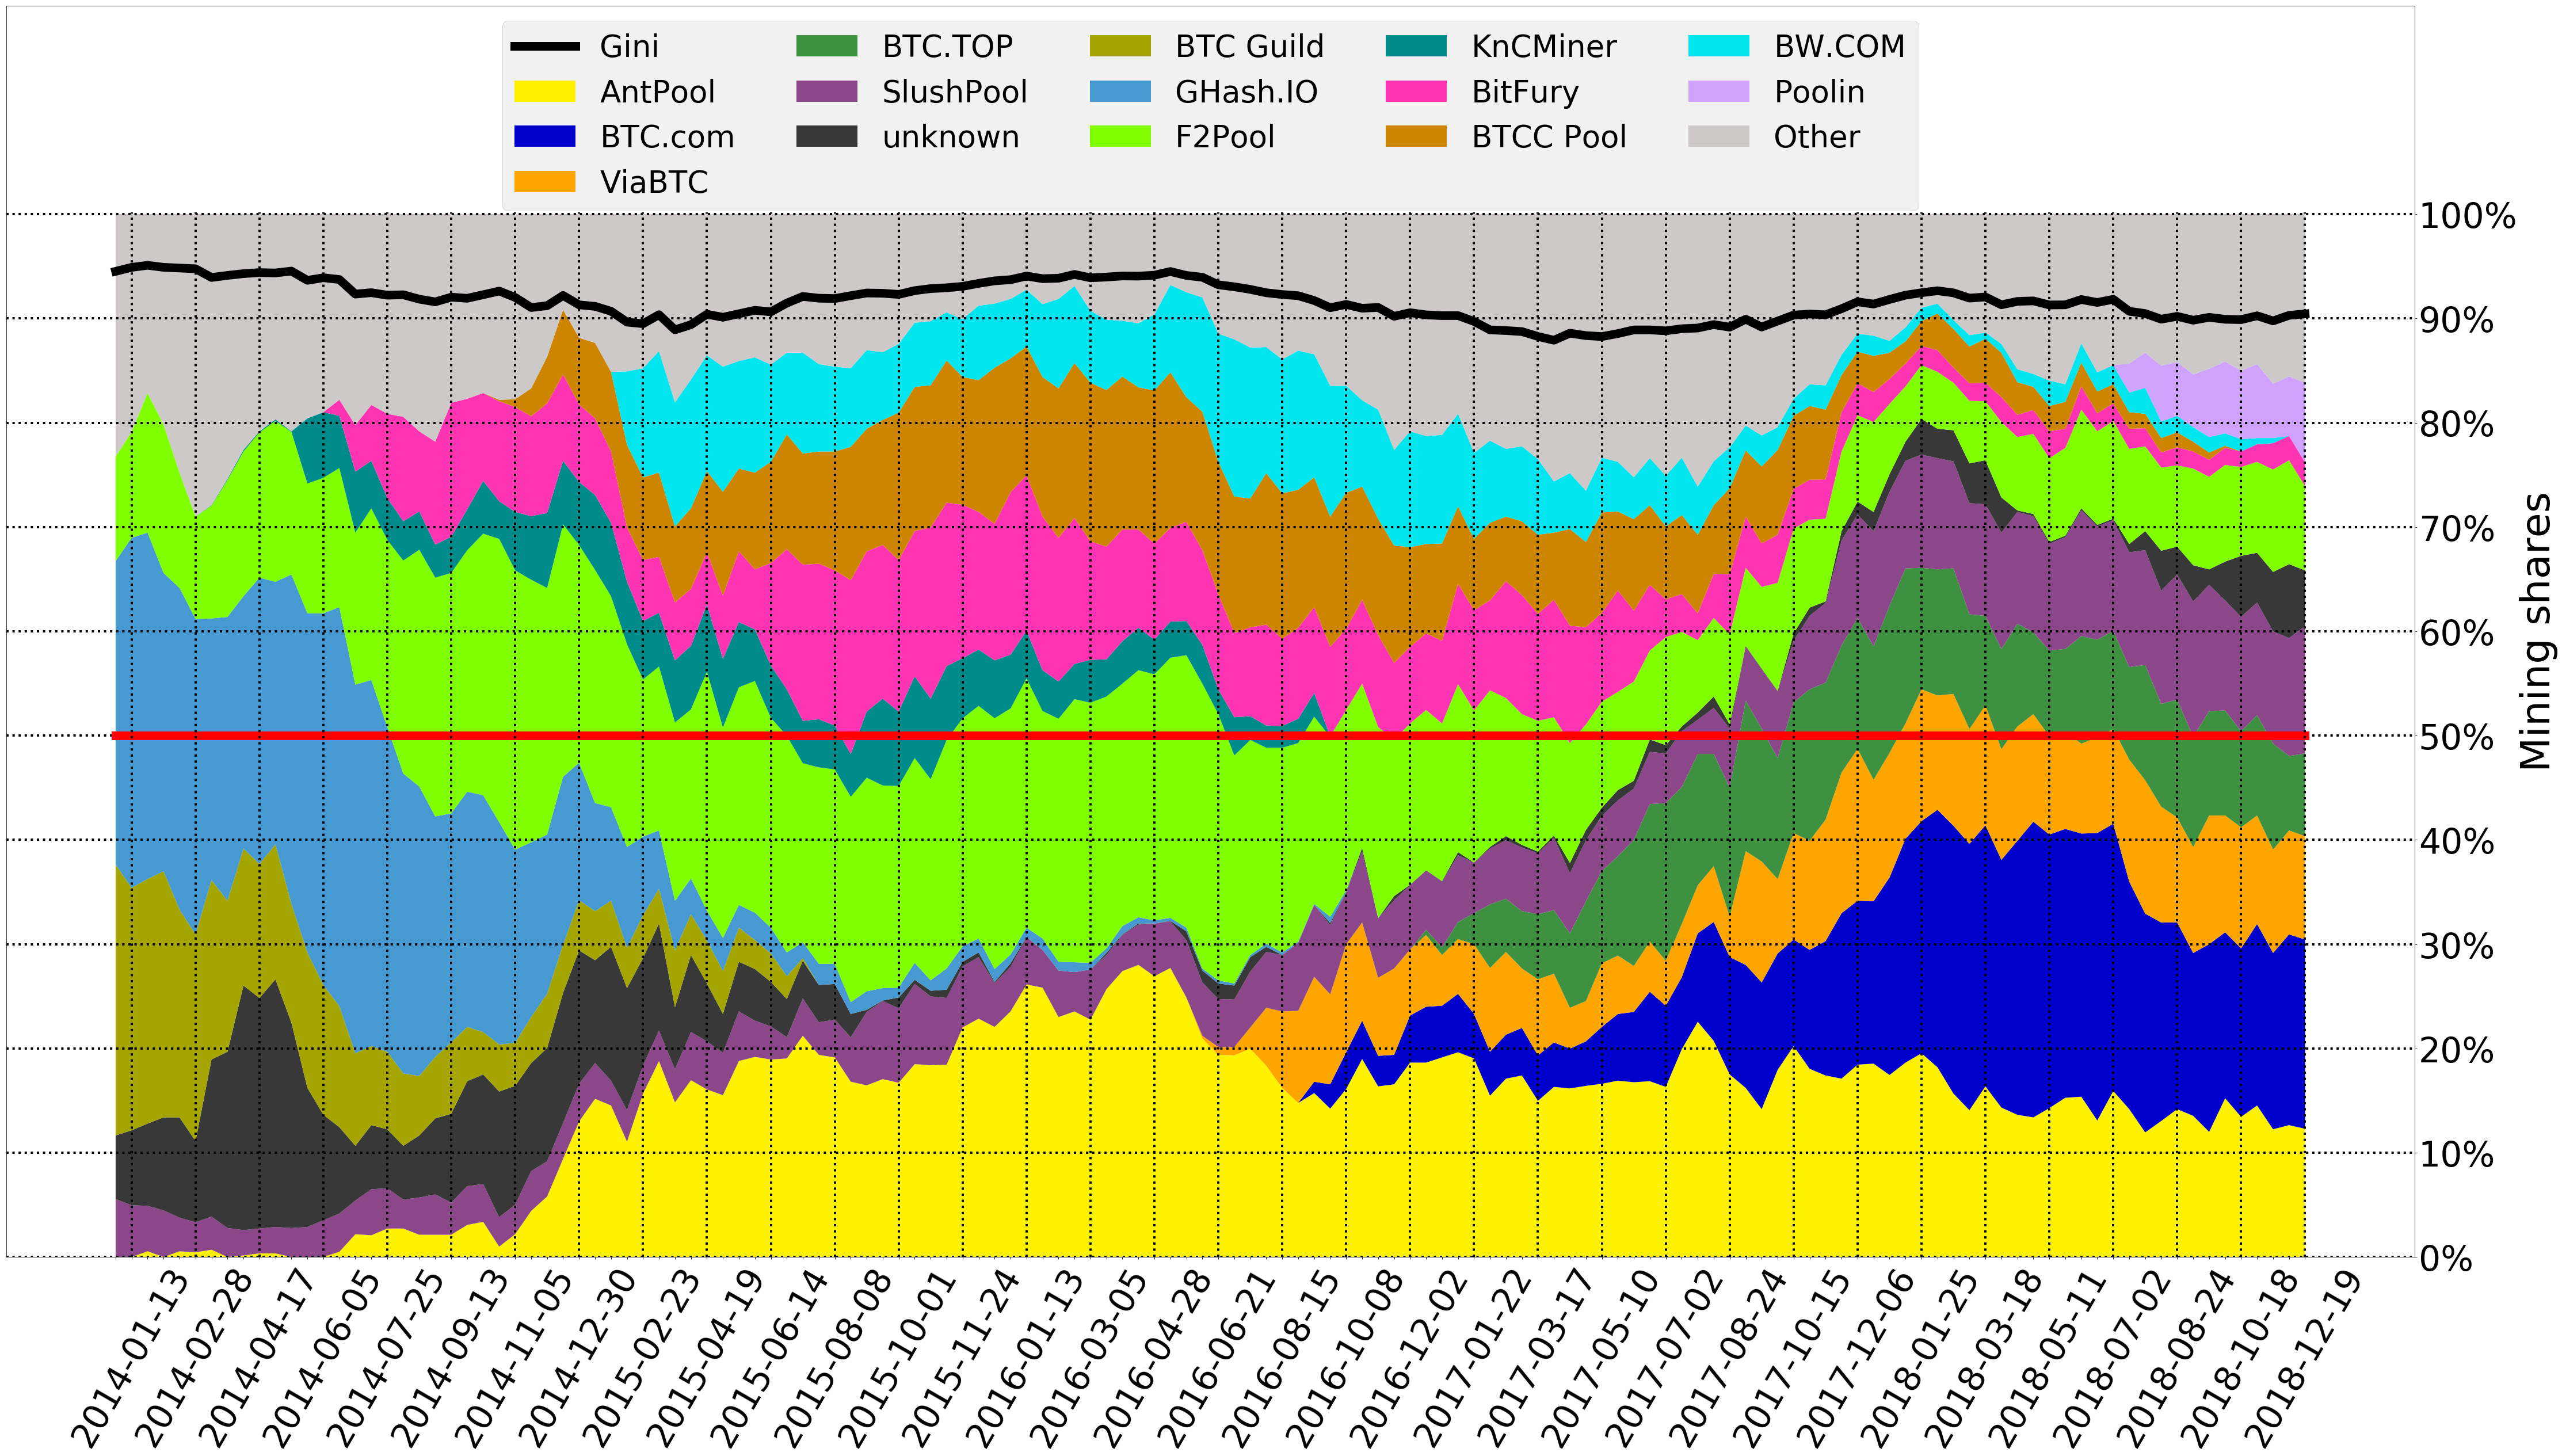

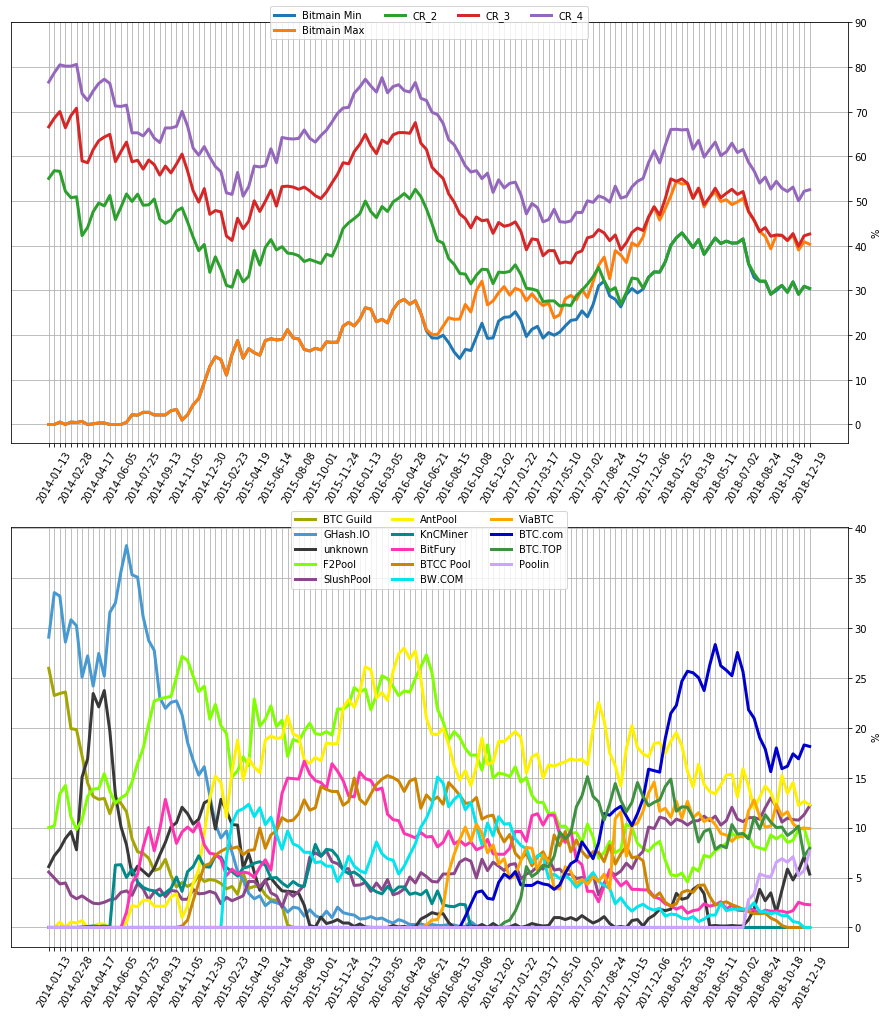

In [32]:
end_height= 554399  # right before difficulty change
# num_periods = 52*4 + 1
# num_periods = 157
num_periods = 138
period_len = 2016
shares_threshold = 4
y_th_dict = print_stack_plot(end_height, period_len=period_len, num_periods=num_periods, \
                             save=True, threshold=shares_threshold, print_decentralization=True)